## Loading Packages

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tnrange
import numpy as np
%matplotlib inline

## Data

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train = dsets.MNIST("./Mnist/",train=True,transform=img_transform,download=True)
test = dsets.MNIST("./Mnist/",train=False,transform=img_transform,download=True)

In [4]:
img = train[0][0]

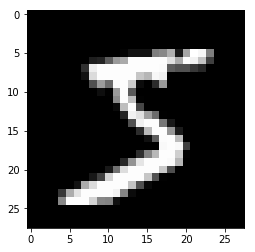

In [5]:
plt.imshow(img.numpy().reshape(28,28),cmap="gray")

## Convert Data to Iterable

In [6]:
train_data = torch.utils.data.DataLoader(train,batch_size=128,shuffle=True)
test_data = torch.utils.data.DataLoader(test,batch_size=128,shuffle=False)

## Building Model

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        
        self.fc1_en = nn.Linear(784,500)
        self.relu1 =nn.ReLU()
        
        self.fc2_mean = nn.Linear(500,20)
        self.fc2_stddev =nn.Linear(500,20)
        
        self.fc1_dec1 = nn.Linear(20,500)
        self.relu2 = nn.ReLU()
        
        self.fc2_dec2 = nn.Linear(500,784)
        self.sigm2 = nn.Sigmoid()
        
    def encoder(self,x):
        
        out = self.fc1_en(x.view(-1,28*28))
        out= self.relu1(out)
        
        z_mean = self.fc2_mean(out)
        z_stddev = self.fc2_stddev(out)
        
        return z_mean,z_stddev
    
    def sampling(self,z_mean,z_stddev):
        sd = torch.exp(z_stddev*0.5)
        e = Variable(torch.randn(sd.size()))
        z = e.mul(sd).add_(z_mean)
        return z
        
    def decoder(self,z):
        
        out = self.fc1_dec1(z)
        out = self.relu2(out)
        
        out= self.fc2_dec2(out)
        out = self.sigm2(out)
        
        return out
        
    def forward(self,x):
        
        z_mean,z_stddev = self.encoder(x)
        z = self.sampling(z_mean,z_stddev)
        out = self.decoder(z)
        
        return out,z_mean,z_stddev      

## Instantiating Model class

In [8]:
Model = VAE()

## Loss function

In [9]:
def lossfun(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0) # normalize by batch size
    return loss

## Optimizer

In [10]:
optimizer = torch.optim.Adam(Model.parameters())

## Training

In [11]:
epochs = int(7)

In [12]:
losses = []
for i in tnrange(epochs,desc = 'Epochs'):
    for j,(images,labels) in enumerate(train_data):
        images = Variable(images.view(-1,28*28))
        
        out,z_mean,z_stddev = Model.forward(images)
        
        total_loss = lossfun(out,images,z_mean,z_stddev)
        
        optimizer.zero_grad()
        
        total_loss.backward()
        
        optimizer.step()
        
        losses.append(total_loss.data[0])
    print("Epoch : {} Train_error : {}".format(i,total_loss) )

C:\Users\IIST\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch : 0 Train_error : -16481.314453125


KeyboardInterrupt: 

## Loss Visualisation

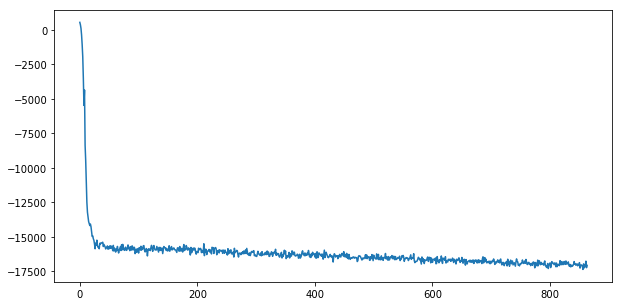

In [13]:
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.show()

In [ ]:
from torchvision.utils import make_grid as make_image_grid

## Visualise input VAE and Reconsruction

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0))) ## 1,28,28  28,28,1
    plt.axis('off')
    plt.show()
        
images,_ = iter(test_data).next()
images = images[0:16,:,:]
x_in = Variable(images)
x_out,_,_ = Model(x_in)
x_out = x_out.data
x_out = x_out.view(16,1,28,28)
imshow(make_image_grid(images))
imshow(make_image_grid(x_out))

In [ ]:
make_image_grid(images)